In [1]:
import matplotlib.pyplot as plt
import time
from IPython.display import display
from xml.dom import minidom
import math
import folium
import pandas as pd
from pandas.io.json import json_normalize
import tqdm 
import numpy as np
import geopandas as gpd
import contextily as cx
from random import randint
import json

import warnings
warnings.filterwarnings("ignore")

# Routes

In [2]:
routes= gpd.read_file('./data/transit_map/gtfs_dependencies/make_gtfs/data/khartoum/shapes.geojson')
routes.head()

,shape_id,geometry
0,shp_4,"LINESTRING (32.52187 15.59309, 32.52191 15.593..."
1,shp_5,"LINESTRING (32.52187 15.59309, 32.52187 15.593..."
2,shp_6,"LINESTRING (32.52187 15.59309, 32.52187 15.593..."
3,shp_8,"LINESTRING (32.52187 15.59309, 32.52187 15.593..."
4,shp_10,"LINESTRING (32.52187 15.59309, 32.52187 15.593..."


In [3]:
routes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

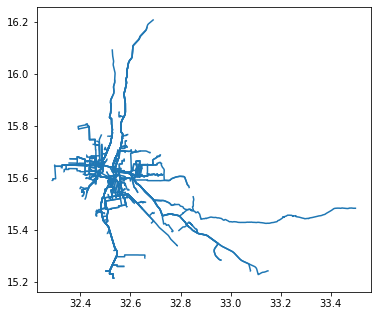

In [4]:
routes.plot(figsize=(6, 6))

In [5]:
color = []
n = len(routes)

for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))

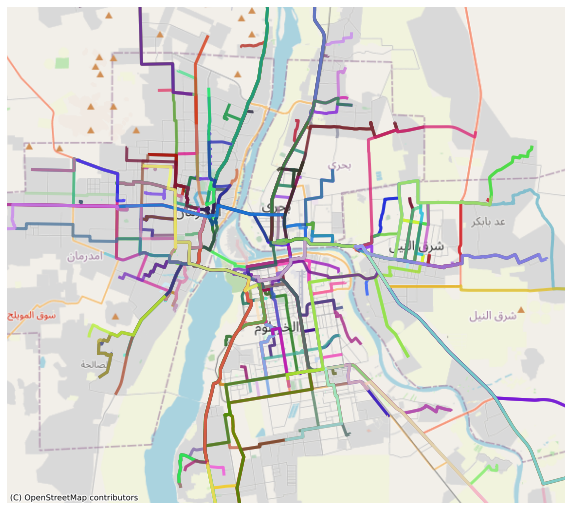

In [6]:
ax = routes.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.75, linewidth= 3, edgecolor=color, legend= True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom= 11)
plt.xlim([3600000, 3645000])
plt.ylim([1740000, 1780000])
ax.set_axis_off()

#plt.savefig('validated_map_.jpg')

# Neighborhoods

In [7]:
#for neighborhoods geojson
from shapely import wkt

neighborhoods= gpd.read_file('data/gis/other_layers/krt_neighborhoods.json')

neighborhoods['PAU_NAME']= neighborhoods.PAU_NAME.str.encode('cp1252')
neighborhoods['PAU_NAME']= neighborhoods.PAU_NAME.str.decode('cp1256')

neighborhoods['Loc_Name']= neighborhoods.Loc_Name.str.encode('cp1252')
neighborhoods['Loc_Name']= neighborhoods.Loc_Name.str.decode('cp1256')

neighborhoods['AU_Name']= neighborhoods.AU_Name.str.encode('cp1252')
neighborhoods['AU_Name']= neighborhoods.AU_Name.str.decode('cp1256')

neighborhoods['PAU_NAME_1']= neighborhoods.PAU_NAME_1.str.encode('cp1252')
neighborhoods['PAU_NAME_1']= neighborhoods.PAU_NAME_1.str.decode('cp1256')

neighborhoods['Loc_Name_1']= neighborhoods.Loc_Name_1.str.encode('cp1252')
neighborhoods['Loc_Name_1']= neighborhoods.Loc_Name_1.str.decode('cp1256')

neighborhoods['AU_Name_1']= neighborhoods.AU_Name_1.str.encode('cp1252')
neighborhoods['AU_Name_1']= neighborhoods.AU_Name_1.str.decode('cp1256')

In [8]:
neighborhoods.columns = [x.lower() for x in neighborhoods.columns]
neighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

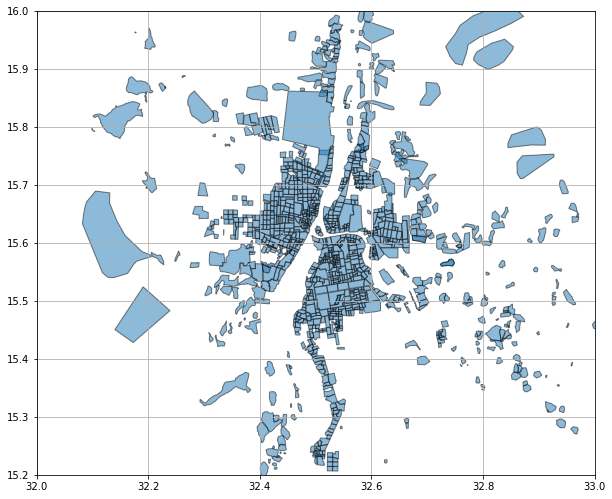

In [9]:
ax = neighborhoods.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
plt.xlim([32.00, 33.00])
plt.ylim([15.20, 16.00])
plt.grid()

In [10]:
color = []
n = len(neighborhoods)

for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))

In [11]:
#neighborhoods['House_Hold']= neighborhoods.House_Hold.replace(' ', 0).astype('int')
neighborhoods= neighborhoods.drop(neighborhoods[neighborhoods.house_hold == ' '].index.values)
neighborhoods['house_hold']= neighborhoods.house_hold.astype('int')
neighborhoods= neighborhoods[neighborhoods.house_hold <= 3000] #filtering out one extreme neigborhood

## Survey Responses

In [13]:
data= pd.read_excel('data/mobility_survey/khartoum_mobility_survey.xlsx')
#data= pd.read_csv('matched_responces.csv') #for reading processed data

print(data.shape)
data.head()

(6897, 26)


,Timestamp,per_day,per_week,purpose,route,cost,access,access_time,safety,origin_locality,...,concerns,age,sex,employment,income,income_source,household_size,household_youth,household_cars,og_team_member_id
0,2023-03-06 10:55:22.508,2 times/day - مرتين في اليوم,1 to 2 days per week - يوم إلى يومين في الاسبوع,"Work - للوصول لمكان العمل, School/University ...",عربي- بري,30000.0,Ride with friend - بوصلك صاحبك/ملحة/سيفتي؟,NaN,I only feel safe during daytime - أشعر بالأمان...,Omdurman - أمدرمان,...,"Cost - السعر, Driver Behavior - سلوك السائقي...",25-34,Female - أنثى,Freelancer - مستقل\أعمال حرة,"150,000-300,000 pounds - بين 150-300 ألف جنيه",Private Business - عمل خاص,4,0,1,NaN
1,2023-03-06 10:56:20.084,Occasionally - أحياناً,1 to 2 days per week - يوم إلى يومين في الاسبوع,"Work - للوصول لمكان العمل, School/University ...",المركز الإسلامي - جامعة السودان العالمية الازهري,4000.0,Walk - عن طريق المشي (كداري),Less than 5 mins - أقل من 5 دقايق,I only feel safe during daytime - أشعر بالأمان...,Khartoum - الخرطوم,...,Personal Safety - السلامة الشخصية,25-34,Male - ذكر,Full-Time Employee - موظف بدوام كامل,"100,000-150,000 pounds - بين 100-150 ألف جنيه",Employment - الوظيفة,5,5,2,NaN
2,2023-03-06 11:33:32.494,More than 2 times/day - أكثر من مرتين في اليوم,Everyday - كل أيام الاسبوع,"Work - للوصول لمكان العمل, School/University ...",السوق المركزي - الكدرو,17000.0,Ride with friend - بوصلك صاحبك/ملحة/سيفتي؟,10-20 mins - من 10-20 دقيقة,I only feel safe during daytime - أشعر بالأمان...,Khartoum - الخرطوم,...,"Cost - السعر, Availability - توفر المواصلات,...",25-34,Male - ذكر,University Student - طالب جامعي,"100,000-150,000 pounds - بين 100-150 ألف جنيه",Employment - الوظيفة,3,0,1,NaN
3,2023-03-06 12:15:43.167,More than 2 times/day - أكثر من مرتين في اليوم,3 to 5 days per week - ثلاثه الى خمسه أيام في ...,"Work - للوصول لمكان العمل, School/University ...",صالحة-عربي,30000.0,Walk - عن طريق المشي (كداري),Less than 5 mins - أقل من 5 دقايق,"Yes, I feel safe. - نعم أشعر بالأمان",Omdurman - أمدرمان,...,Overcrowding - زحمة المواصلات,18-24,Male - ذكر,Full-Time Employee - موظف بدوام كامل,"300,000-750,000 pounds - بين 300-750 ألف جنيه",Employment - الوظيفة,6,1,1,NaN
4,2023-03-06 13:31:31.832,Never - لا استخدم المواصلات,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bahri - بحري,...,Nothing,55 and over - أ55 أو أكبر,Female - أنثى,Full-Time Employee - موظف بدوام كامل,"Less than 50,000 pounds - أقل من 50 ألف جنيه",Employment - الوظيفة,69,420,More than 2 - أكثر من 2,NaN


count      5676.000000
mean      22211.800352
std       17973.273599
min           0.000000
25%       10000.000000
50%       20000.000000
75%       30000.000000
max      100000.000000
Name: cost, dtype: float64


<AxesSubplot:>

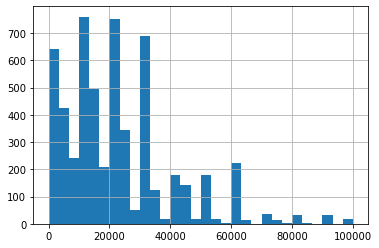

In [14]:
print(data.cost.describe())
data.cost.hist(bins=30)

count    6897.000000
mean        6.125127
std         9.931574
min         0.000000
25%         4.000000
50%         6.000000
75%         7.000000
max       600.000000
Name: household_size, dtype: float64


<AxesSubplot:>

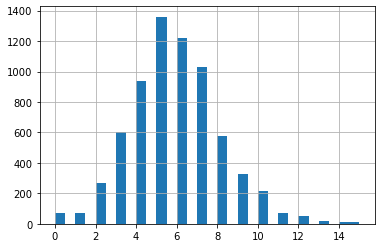

In [15]:
print(data.household_size.describe())
data[data.household_size <= 15].household_size.hist(bins=30)

count    6897.000000
mean        1.964332
std         5.546827
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       420.000000
Name: household_youth, dtype: float64


<AxesSubplot:>

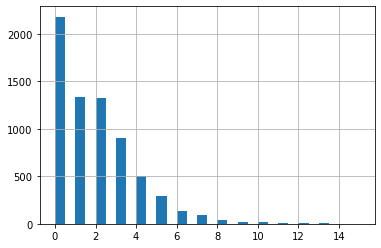

In [16]:
print(data.household_youth.describe())
data[data.household_youth <= 15].household_youth.hist(bins=30)

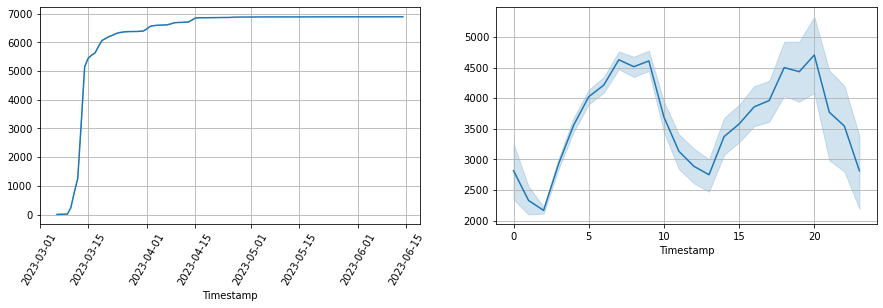

In [17]:
import seaborn as sns
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.lineplot(x= data.Timestamp.dt.date, y= data.index.values)
plt.xticks(rotation=60)
plt.grid()

plt.subplot(1,2,2)
sns.lineplot(x= data.Timestamp.dt.hour, y= data.index.values) #Hour is in US EST (KRT - 6)
plt.grid()

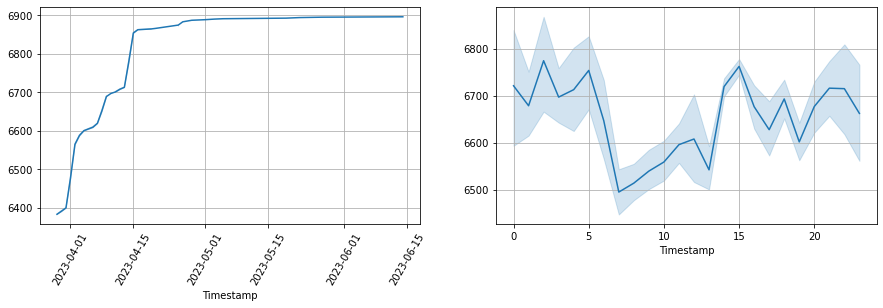

In [18]:
#for new social media data
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)

subset= data[data.Timestamp >= '2023-03-29 00:00:00']
sns.lineplot(x= subset.Timestamp.dt.date, y= subset.index.values)
plt.xticks(rotation=60)
plt.grid()

plt.subplot(1,2,2)
sns.lineplot(x= subset.Timestamp.dt.hour, y= subset.index.values) #Hour is in US EST (KRT - 6)
plt.grid()

In [19]:
#comparing age groups
print('For all data:')
display(pd.DataFrame(data.age.value_counts(normalize= True)).round(3)*100)
print('For sponsored social media:')
display(pd.DataFrame(subset.age.value_counts(normalize= True)).round(3)*100)

For all data:


,age
25-34,45.2
18-24,24.5
35-44,20.6
45-54,5.7
55 and over - أ55 أو أكبر,1.6
Prefer not to answer - افضل عدم الاجابة على هذا السؤال,1.4
Under 18 - أقل من 18 سنة,1.0


For sponsored social media:


,age
18-24,41.6
25-34,37.4
35-44,10.9
45-54,4.7
Under 18 - أقل من 18 سنة,3.1
55 and over - أ55 أو أكبر,1.6
Prefer not to answer - افضل عدم الاجابة على هذا السؤال,0.8


In [20]:
print(data.origin.value_counts())
print(data.destination.value_counts())

جبرة                150
كافوري              100
اركويت               97
شمبات                93
الازهري              93
                   ... 
الحارة ١٢             1
يثرب الشجرة           1
الثورة الحارة 62      1
حي الواحه             1
دار المصطفى           1
Name: origin, Length: 2368, dtype: int64
السوق العربي      484
العربي            342
السوق العربي      195
الخرطوم           146
الرياض            139
                 ... 
بحري كوبر           1
السلمه              1
الخرطوم العمل       1
جعفر بن عوف         1
العمارات ، ش25      1
Name: destination, Length: 2076, dtype: int64


In [21]:
data['origin']= data.origin.astype('str').apply(lambda x: x.replace('أ','ا').replace('ة','ه').replace('ى','ي'))
data['destination']= data.destination.astype('str').apply(lambda x: x.replace('أ','ا').replace('ة','ه').replace('ى','ي'))
print(data.origin.value_counts())
print(data.destination.value_counts())

جبره                 204
الثوره               116
اركويت               114
الازهري              111
كافوري               101
                    ... 
الشغله شرق مربع 2      1
جادين                  1
جبره 13                1
مربع ٣٦                1
دار المصطفي            1
Name: origin, Length: 2114, dtype: int64
السوق العربي           496
العربي                 348
السوق العربي           197
جامعه الخرطوم          157
الخرطوم                146
                      ... 
 السجانه                 1
الثوره ح 1               1
كليه المدائن             1
الخرطوم ... الرياض       1
العمارات ، ش25           1
Name: destination, Length: 1864, dtype: int64


In [22]:
#get counts
neighborhoods.loc_name.value_counts()

شرق النيل     244
امدرمان       181
جبل أولياء    167
الخرطوم       148
أم بده        145
كررى          132
بحري           88
بحرى شمال      86
كرري           37
ام بده          1
Name: loc_name, dtype: int64

In [23]:
#fix naming
neighborhoods.loc_name[neighborhoods.loc_name == 'بحرى شمال'] = 'بحري'
neighborhoods['loc_name']= neighborhoods.loc_name.apply(lambda x: x.replace('أ','ا').replace('ة','ه').replace('ى','ي'))
neighborhoods['au_name']= neighborhoods.au_name.apply(lambda x: x.replace('أ','ا').replace('ة','ه').replace('ى','ي'))
neighborhoods.loc_name.value_counts()

شرق النيل     244
امدرمان       181
بحري          174
كرري          169
جبل اولياء    167
الخرطوم       148
ام بده        146
Name: loc_name, dtype: int64

<AxesSubplot:>

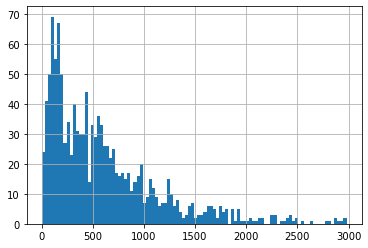

In [24]:
neighborhoods.dropna(subset=['fid'], inplace= True)
neighborhoods.reset_index(drop= True, inplace= True)
neighborhoods.house_hold.hist(bins= 100)

In [25]:
neighborhoods.groupby(['loc_name', 'au_name'])[['fid']].count()

fid
loc_name   au_name           
الخرطوم    الخرطوم شرق     32
           الخرطوم شمال    20
           الخرطوم غرب     15
           الخرطوم وسط     27
           الشجره          15
           الشهداء وسوبا   39
ام بده     الامير          30
           البقعه          38
           الريف الغربي    40
           السلام          38
امدرمان    ابو سعد         42
           ابو عنجه        13
           الريف الجنوبي   68
           الفتيحاب        10
           المورده         14
           حي العرب        17
           ود نوباوي       17
بحري       الجيلي          48
           السليت          38
           بحري شمال       54
           بلديه بحري      34
جبل اولياء الازهري         35
           الكلاكلات       43
           النصر           24
           جبل اولياء      65
شرق النيل  الحاج يوسف      14
           العسيلات        13
           العيلفون        38
           ام ضوابان       38
           شرق النيل       47
           وادي ابو صالح   39
           وادي سوبا       55
كرري       الثورات         37
           الريف الشمالي   68
           كرري            64

In [26]:
trial= ['الخرطوم شرق', 'اركويت جامعه', 'الكلاكلة', 'كافوري', 'صالحه', 'الأزهري', 'المهندسين', 'الدروشاب']

In [27]:
#using difflib
import difflib
def string_similarity(str1, str2):
    str1= ''.join([i for i in str1 if not i.isdigit()])
    str2= ''.join([i for i in str2 if not i.isdigit()])
    str2= str2.replace('أ','ا').replace('ة','ه').replace('ى','ي')
    #str2= str2[:len(str2.partition(' ')[0])+3]
    str1= str1.replace('أ','ا').replace('ة','ه').replace('ى','ي')[:len(str2)]
    result =  difflib.SequenceMatcher(a=str1, b=str2)
    return result.ratio()

In [28]:
#using bioalign
from Bio.Align import PairwiseAligner
def string_similarity_(str1, str2):
    aligner = PairwiseAligner()
    return aligner.score(str1, str2)/len(str2)

In [29]:
match= []

for t in range(len(trial)):
    max_score= 0
    max_index= 0
    for n in range(len(neighborhoods.pau_name)):
        score= string_similarity(neighborhoods.pau_name.iat[n], trial[t])
#         score_au= string_similarity(neighborhoods.au_name.iat[n], trial[t])
#         score = score_au if score_au > score else score
        #score= string_similarity(str(neighborhoods.pau_name[n].replace('أ','ا').replace('ة','ه')),
        #                         str(trial[t].replace('أ','ا').replace('ة','ه')))
        #score= string_similarity(str(neighborhoods.pau_name[n].encode), str(trial[t].encode))
        #max_score= score if score > max_score else score
        if score > max_score:
            max_score = score
            max_index = n
    if max_score <= 0.75:
        match.append([trial[t], 'No Match Found', round(max_score,3)])
    else:
        match.append([trial[t], neighborhoods.pau_name.iat[max_index], round(max_score,3)])

In [30]:
print(match)

[['الخرطوم شرق', 'الخرطوم 3 شرق', 0.909], ['اركويت جامعه', 'اركويت مربع61', 0.783], ['الكلاكلة', 'No Match Found', 0.75], ['كافوري', 'كافوري', 1.0], ['صالحه', 'صالحة شرق', 1.0], ['الأزهري', 'الازهري م2-6', 1.0], ['المهندسين', 'المهندسين م29', 1.0], ['الدروشاب', 'الدروشاب جنوب مربع1', 1.0]]


In [ ]:
#for survey data
data['matched_origin'] = None
data['matching_score'] = 0

with tqdm.tqdm(total= len(data), position=0, leave=True) as pbar:
    for o in range(len(data)):
        pbar.update(1)
        max_score= 0
        max_index= 0
        for n in range(len(neighborhoods.pau_name)):
            score= string_similarity(neighborhoods.pau_name.iat[n], data.origin[o])
#             score_au= string_similarity(neighborhoods.au_name.iat[n], data.origin[o])
#             score = score_au if score_au > score else score

            if score > max_score:
                max_score = score
                max_index = n
        if max_score <= 0.75:
            data.at[o, 'matched_origin'] = 'No Match Found'
        else:
            data.at[o, 'matched_origin'] = neighborhoods.pau_name.iat[max_index]
            data.at[o, 'matching_score'] = round(max_score,3)

In [ ]:
#show matching diagnostics
print(f'Percent unmatched= {round(len(data[data.matched_origin == "No Match Found"])/len(data),3)*100}')
data[['origin', 'matched_origin', 'matching_score']]

In [ ]:
#similarly for destinations
#for survey data
data['matched_destination'] = None
data['matching_score_d'] = 0

with tqdm.tqdm(total= len(data), position=0, leave=True) as pbar:
    for o in range(len(data)):
        pbar.update(1)
        max_score= 0
        max_index= 0
        for n in range(len(neighborhoods.pau_name)):
            score= string_similarity(neighborhoods.pau_name.iat[n], data.destination[o])
            if score > max_score:
                max_score = score
                max_index = n
        if max_score <= 0.75:
            data.at[o, 'matched_destination'] = 'No Match Found'
        else:
            data.at[o, 'matched_destination'] = neighborhoods.pau_name.iat[max_index]
            data.at[o, 'matching_score_d'] = round(max_score,3)
            
print(f'Percent unmatched= {round(len(data[data.matched_destination == "No Match Found"])/len(data),3)*100}')
data[['destination', 'matched_destination', 'matching_score_d']]

In [ ]:
neighborhoods['survey_count'] = 0

with tqdm.tqdm(total= len(neighborhoods), position= 0, leave= True) as pbar:
    for n in range(len(neighborhoods)):
        pbar.update(1)
        try:
            neighborhoods.survey_count.iat[n]= data.matched_origin.value_counts()[neighborhoods.pau_name.iat[n]]
        except:
            continue

In [ ]:
ax = neighborhoods.to_crs(epsg=3857).plot(column= 'survey_count', figsize=(15, 15), alpha=0.75, cmap= 'turbo',
                                          scheme= 'user_defined',
                                          classification_kwds=dict(bins=[1, 10,20,30,40,50]),
                                          linewidth= 1, edgecolor='k', legend= True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom= 11)
plt.xlim([3595000, 3650000])
plt.ylim([1730000, 1785000])
ax.set_axis_off()

#plt.savefig('validated_map_.jpg')

# using GeoCode

In [ ]:
#using geocoding to match unmatched origins and destinations
gcd_data= data[data.matched_origin == 'No Match Found']

In [ ]:
gcd_data['location'] = gcd_data.origin+', الخرطوم, السودان'

In [ ]:
test= gpd.tools.geocode(gcd_data.location.sample(10))
test= test.to_crs(epsg=4326)

In [ ]:
test.address

In [ ]:
ax = neighborhoods.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
test.plot(ax=ax, c='r')
plt.xlim([32.00, 33.00])
plt.ylim([15.20, 16.00])
plt.grid()

In [ ]:
from shapely.geometry import Point, Polygon

test['pau_name'] = 'Unknown'
with tqdm.tqdm(total= len(test), position=0, leave=True) as pbar:
    for i in range(len(test)):
        pbar.update(1)
        for j in range(len(neighborhoods)):
            try:
                if Polygon(neighborhoods.geometry.iat[j]).contains(Point(test.geometry.iat[i])):
                    test.pau_name.iat[i]= neighborhoods.pau_name.iat[j]
            except:
                continue

print('After matching:')
test

In [ ]:
#geocode everything
#use batches and wait 10 sec between batches to avoid errors due to gcd server limits
counter = 0
batch = 20
gcd = pd.DataFrame()

with tqdm.tqdm(total= np.ceil(len(gcd_data)/batch), position=0, leave=True) as pbar:
    for i in range(int(np.ceil(len(gcd_data)/batch))):
        pbar.update(1)
        while True:
            try:
                test= gpd.tools.geocode(gcd_data.location[counter:counter+batch])
                gcd= pd.concat([gcd, test])
                counter += batch
            except:
                print(f'Connection Breakdown at Batch: {i+1} \n')
                print(f'Retrying...')
                continue
            break
        time.sleep(10) #break down requests
gcd= gcd.to_crs(epsg=4326)

In [ ]:
gcd['pau_name'] = 'Unknown'

with tqdm.tqdm(total= len(gcd), position=0, leave=True) as pbar:
    for i in range(len(gcd)):
        pbar.update(1)
        for j in range(len(neighborhoods)):
            try:
                if Polygon(neighborhoods.geometry.iat[j]).contains(Point(gcd.geometry.iat[i])):
                    gcd.pau_name.iat[i]= neighborhoods.pau_name.iat[j]
            except:
                continue

In [ ]:
for response in gcd.index.values:
    data.matched_origin.at[response] = gcd.pau_name.at[response]
    
print(f'Percent unmatched= {round(len(data[data.matched_origin == "Unknown"])/len(data),3)*100}')
data[['origin', 'matched_origin', 'matching_score']].sample(10)

In [ ]:
neighborhoods['survey_count'] = 0

with tqdm.tqdm(total= len(neighborhoods), position= 0, leave= True) as pbar:
    for n in range(len(neighborhoods)):
        pbar.update(1)
        try:
            neighborhoods.survey_count.iat[n]= data.matched_origin.value_counts()[neighborhoods.pau_name.iat[n]]
        except:
            continue

In [ ]:
ax = neighborhoods.to_crs(epsg=3857).plot(column= 'survey_count', figsize=(10, 10), alpha=0.75, cmap= 'turbo',
                                          scheme= 'user_defined',
                                          classification_kwds=dict(bins=[1,20,30,40,50,100]),
                                          linewidth=1, edgecolor='k', legend= True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom= 11)
plt.xlim([3595000, 3650000])
plt.ylim([1730000, 1785000])
ax.set_axis_off()

#plt.savefig('mobility_survey_origins.jpg') #print on 20x20

In [ ]:
ax = neighborhoods.to_crs(epsg=3857).plot(column= 'survey_count', figsize=(10, 10), alpha=0.75, cmap= 'turbo',
                                          scheme= 'user_defined',
                                          classification_kwds=dict(bins=[1,20,30,40,50,100]),
                                          linewidth= 0.50, edgecolor='k', legend= True)
routes.to_crs(epsg=3857).plot(ax=ax, alpha=1.0, linewidth= 2, edgecolor=color, legend= True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom= 11)
plt.xlim([3595000, 3650000])
plt.ylim([1730000, 1785000])
ax.set_axis_off()

#plt.savefig('routes.jpg') #print on 20x20

In [ ]:
#same thing for destinations
#if it breaks, remove everything until creating gcd and replace tqdm total - i, i range(i,int(np.ceil...))

gcd_data= data[data.matched_destination == 'No Match Found']
gcd_data['location'] = gcd_data.destination+', الخرطوم, السودان'

counter = 0
batch = 20
gcd = pd.DataFrame()

print('Geocoding in Progress...')
with tqdm.tqdm(total= np.ceil(len(gcd_data)/batch), position=0, leave=True) as pbar:
    for i in range(int(np.ceil(len(gcd_data)/batch))):
        pbar.update(1)
        while True:  
            try:
                test= gpd.tools.geocode(gcd_data.location[counter:counter+batch])
                gcd= pd.concat([gcd, test])
                counter += batch
            except:
                print(f'Connection Breakdown at Batch: {i+1} \n')
                print(f'Retrying...')
                continue
            break
        time.sleep(10) #break down requests
gcd= gcd.to_crs(epsg=4326)
gcd['pau_name'] = 'Unknown'

print('Geocoding Matching...')
with tqdm.tqdm(total= len(gcd), position=0, leave=True) as pbar:
    for i in range(len(gcd)):
        pbar.update(1)
        for j in range(len(neighborhoods)):
            try:
                if Polygon(neighborhoods.geometry.iat[j]).contains(Point(gcd.geometry.iat[i])):
                    gcd.pau_name.iat[i]= neighborhoods.pau_name.iat[j]
            except:
                continue
    
for response in gcd.index.values:
    data.matched_destination.at[response] = gcd.pau_name.at[response]
print(f'Percent unmatched= {round(len(data[data.matched_destination == "Unknown"])/len(data),3)*100}')
data[['destination', 'matched_destination', 'matching_score']].sample(10)

print('Counting...')
neighborhoods['survey_count'] = 0
with tqdm.tqdm(total= len(neighborhoods), position= 0, leave= True) as pbar:
    for n in range(len(neighborhoods)):
        pbar.update(1)
        try:
            neighborhoods.survey_count.iat[n]= data.matched_destination.value_counts()[neighborhoods.pau_name.iat[n]]
        except:
            continue

print('Plotting...')           
ax = neighborhoods.to_crs(epsg=3857).plot(column= 'survey_count', figsize=(10, 10), alpha=0.75, cmap= 'turbo',
                                          scheme= 'user_defined',
                                          classification_kwds=dict(bins=[1,10,25,50,100,250]),
                                          linewidth= 1, edgecolor='k', legend= True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom= 11)
plt.xlim([3595000, 3650000])
plt.ylim([1730000, 1785000])
ax.set_axis_off()

#plt.savefig('mobility_survey_destinations.jpg')

In [ ]:
data.matched_destination

In [ ]:
#data.to_excel('Data/Mobility_Survey/kms_matched_responces.xlsx', index= False)

In [ ]:
x= data.groupby(['matched_origin', 'matched_destination'])[['per_day']].count()
x.reset_index(inplace= True)
x.sort_values('per_day', ascending= False)

In [ ]:
x= data.groupby(['origin_locality', 'destination_locality'])[['per_day']].count()
x.reset_index(inplace= True)
x.sort_values('per_day', ascending= False)

In [ ]:
data.info()

In [ ]:
cat_cols= ['purpose', 'access', 'concerns', 'age', 'sex', 'employment', 'income',
       'income_source', 'household_size', 'household_youth', 'household_cars',
       'og_team_member_id', 'matched_origin', 'matching_score',
       'matched_destination', 'matching_score_d']

= .astype('category')